# Alan Data

i.e. the big one.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from edges_cal import modelling as mdl
from pathlib import Path

import mcmc_utils as mutl
from edges_estimate.eor_models import AbsorptionProfile
from edges_estimate.fitting import SemiLinearFit
from getdist import plots

import alan_data_utils as utils
import alan_data as adata
import glob
import run_alan_data_mcmc as mcmc
from scipy import optimize
import notebook_utils as nutl
import pickle
from multiprocessing import Pool
from astropy import units as u
from edges_cal.modelling import LinLog
from yabf import run_map
plt.ion()

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
nutl.setup_mpl()

In [60]:
runs = mutl.get_completed_mcsamples(mcmc.precal.FOLDER, include_incomplete=True)

outputs/alan_field_and_cal/c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg5_simulTrue_taufxFalse_ns00_nd00_sd1234/bayescal.txt
Removed no burn in
outputs/alan_field_and_cal/c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg6_simulTrue_taufxFalse_ns00_nd00_sd1234/bayescal.txt
Removed no burn in
outputs/alan_field_and_cal/c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg7_simulTrue_taufxFalse_ns00_nd00_sd1234/bayescal.txt
Removed no burn in
outputs/alan_field_and_cal/c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg8_simulTrue_taufxFalse_ns00_nd00_sd1234/bayescal.txt
Removed no burn in


In [61]:
runs

{"c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg4_simulTrue_taufxFalse_ns00_nd00_sd1234": <getdist.mcsamples.MCSamples at 0x7f45cc7eee80>,
 "c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg5_simulTrue_taufxFalse_ns00_nd00_sd1234": <getdist.mcsamples.MCSamples at 0x7f4599a45d00>,
 "c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg6_simulTrue_taufxFalse_ns00_nd00_sd1234": <getdist.mcsamples.MCSamples at 0x7f45a9e8d040>,
 "c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg7_simulTrue_taufxFalse_ns00_nd00_sd1234": <getdist.mcsamples.MCSamples at 0x7f45cc5a1fd0>,
 "c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg8_simulTrue_taufxFalse_ns00_nd00_sd1234": <getdist.mcsamples.MCSamples at 0x7f45cc549ee0>}

In [62]:
lk = mcmc.precal.get_likelihood_from_label("c06_w05_smooth32_tns0500_ign[()]_sim[('open', 'short')]_s11()_antsimFalse_fg4_simulTrue_taufxFalse_ns00_nd00_sd1234")

('open', 'short')


In [63]:
def get_eor_curves(mc):
    
    kw = mcmc.precal.get_kwargs(Path(mc.root).parent.name)
    
    # We have to get nparams this way because we might have constructed with a dodgy .paramnames file.
    lk = mcmc.precal.get_likelihood(**kw)
    pidx = [i for i, p in enumerate(lk.partial_linear_model.child_active_params) if p.name in ("A", "nu0", 'w', 'tau')]
    
    nparams = len(lk.partial_linear_model.child_active_params)

    equal_weight_samples = np.genfromtxt(mc.root + "_equal_weights.txt")[:, 2 : (2 + nparams)]
    
    eor = []
    for sample in equal_weight_samples:
        eor.append(lk.eor_components[0](params=sample[pidx])['eor_spectrum'])
        
    return np.array(eor)
    

In [64]:
eor_curves = {}
for name, mc in runs.items():
    eor_curves[name] = get_eor_curves(mc)

('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')


In [42]:
fiducial_fits = {}
for name, run in runs.items():
    kw = mcmc.precal.get_kwargs(name)
    
    fg = kw['nterms_fg']
    
    if fg in fiducial_fits:
        continue
        
    linlog = mdl.LinLog(n_terms=fg)
    
    # NOTE that this fit has constant variance with frequency!
    slf = SemiLinearFit(
        fg=linlog.at(x=adata.sky_freq), 
        eor=utils.make_absorption(adata.sky_freq),
        spectrum=adata.sky_temp, 
        sigma=0.03
    )
    fiducial_fits[fg] = (slf, slf(dual_annealing_kw={'maxiter':200}))

In [72]:
fiducial_fits_wvar = {}
for name, run in runs.items():
    kw = mcmc.precal.get_kwargs(name)
    lk = mcmc.precal.get_likelihood(**kw)
    
    fg = kw['nterms_fg']
    
    if fg in fiducial_fits_wvar:
        continue
        
    linlog = mdl.LinLog(n_terms=fg)
    
    best = run.samples[np.argmax(-run.loglikes)][:len(lk.partial_linear_model.child_active_params)]
    tns = lk.partial_linear_model.get_ctx(params=best)['tns_field']
    variance = lk.partial_linear_model.data['data_variance']['ant'] * tns**2
    # NOTE that this fit has constant variance with frequency!
    slf = SemiLinearFit(
        fg=linlog.at(x=adata.sky_freq), 
        eor=utils.make_absorption(adata.sky_freq),
        spectrum=adata.sky_temp, 
        sigma=np.sqrt(variance)
    )
    fiducial_fits_wvar[fg] = (slf, slf(dual_annealing_kw={'maxiter':200}))

('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')


In [73]:
def plot_inferred_absorption(use='mean', plot_regions=True):
    
    fig, ax = plt.subplots(len(runs)//3 + (len(runs) % 3 > 0), 3, sharex=True, sharey=True, figsize=(nutl.double_width, 0.75*nutl.double_width))
    
    for irun, (name, mc) in enumerate(runs.items()):
        kw = mcmc.precal.get_kwargs(Path(mc.root).parent.name)
        lk = mcmc.precal.get_likelihood(**kw)
        nparams = len(lk.partial_linear_model.child_active_params)

        pidx = [i for i, p in enumerate(lk.partial_linear_model.child_active_params) if p.name in ("A", "nu0", 'w', 'tau')]
        
        if use in ('mean', 'ml'):
            
            if use == 'mean':
                best = mc.getMeans()[pidx]
            elif use == 'ml':
                best = mc.samples[np.argmax(-mc.loglikes)][pidx]
   
            eor = lk.eor_components[0](params=best)['eor_spectrum']
        elif use == 'median':
            eor = np.median(eor_curves[name], axis=0)
            
        if plot_regions:
            p = np.percentile(eor_curves[name], (2.5, 16, 84, 97.5), axis=0)
         
            ax.flatten()[irun].fill_between(adata.sky_freq, p[0], p[-1], alpha=0.2, color=f"C{irun}", lw=0)
            ax.flatten()[irun].fill_between(adata.sky_freq, p[1], p[-2], alpha=0.4, color=f"C{irun}", lw=0)
            
        ax.flatten()[irun].plot(adata.sky_freq, eor, color=f"C{irun}")
        ax.flatten()[irun].set_title(r"$N_{\rm FG}=%s$"%kw['nterms_fg'])
        
        
        slf, res = fiducial_fits_wvar[kw['nterms_fg']]
        ax.flatten()[irun].plot(adata.sky_freq, slf.get_eor(res.x), color='k', ls='--', label='Isolated ML')
        
    for axx in ax.flatten()[(irun+1):]:
        axx.axis('off')
        
    ax[-1, 0].set_xlabel("Frequency [MHz]")
    ax[-1, 1].set_xlabel("Frequency [MHz]")
    fig.supylabel(r"$\hat{T}_{21}$ [K]")
    #plt.legend()

('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')
('open', 'short')


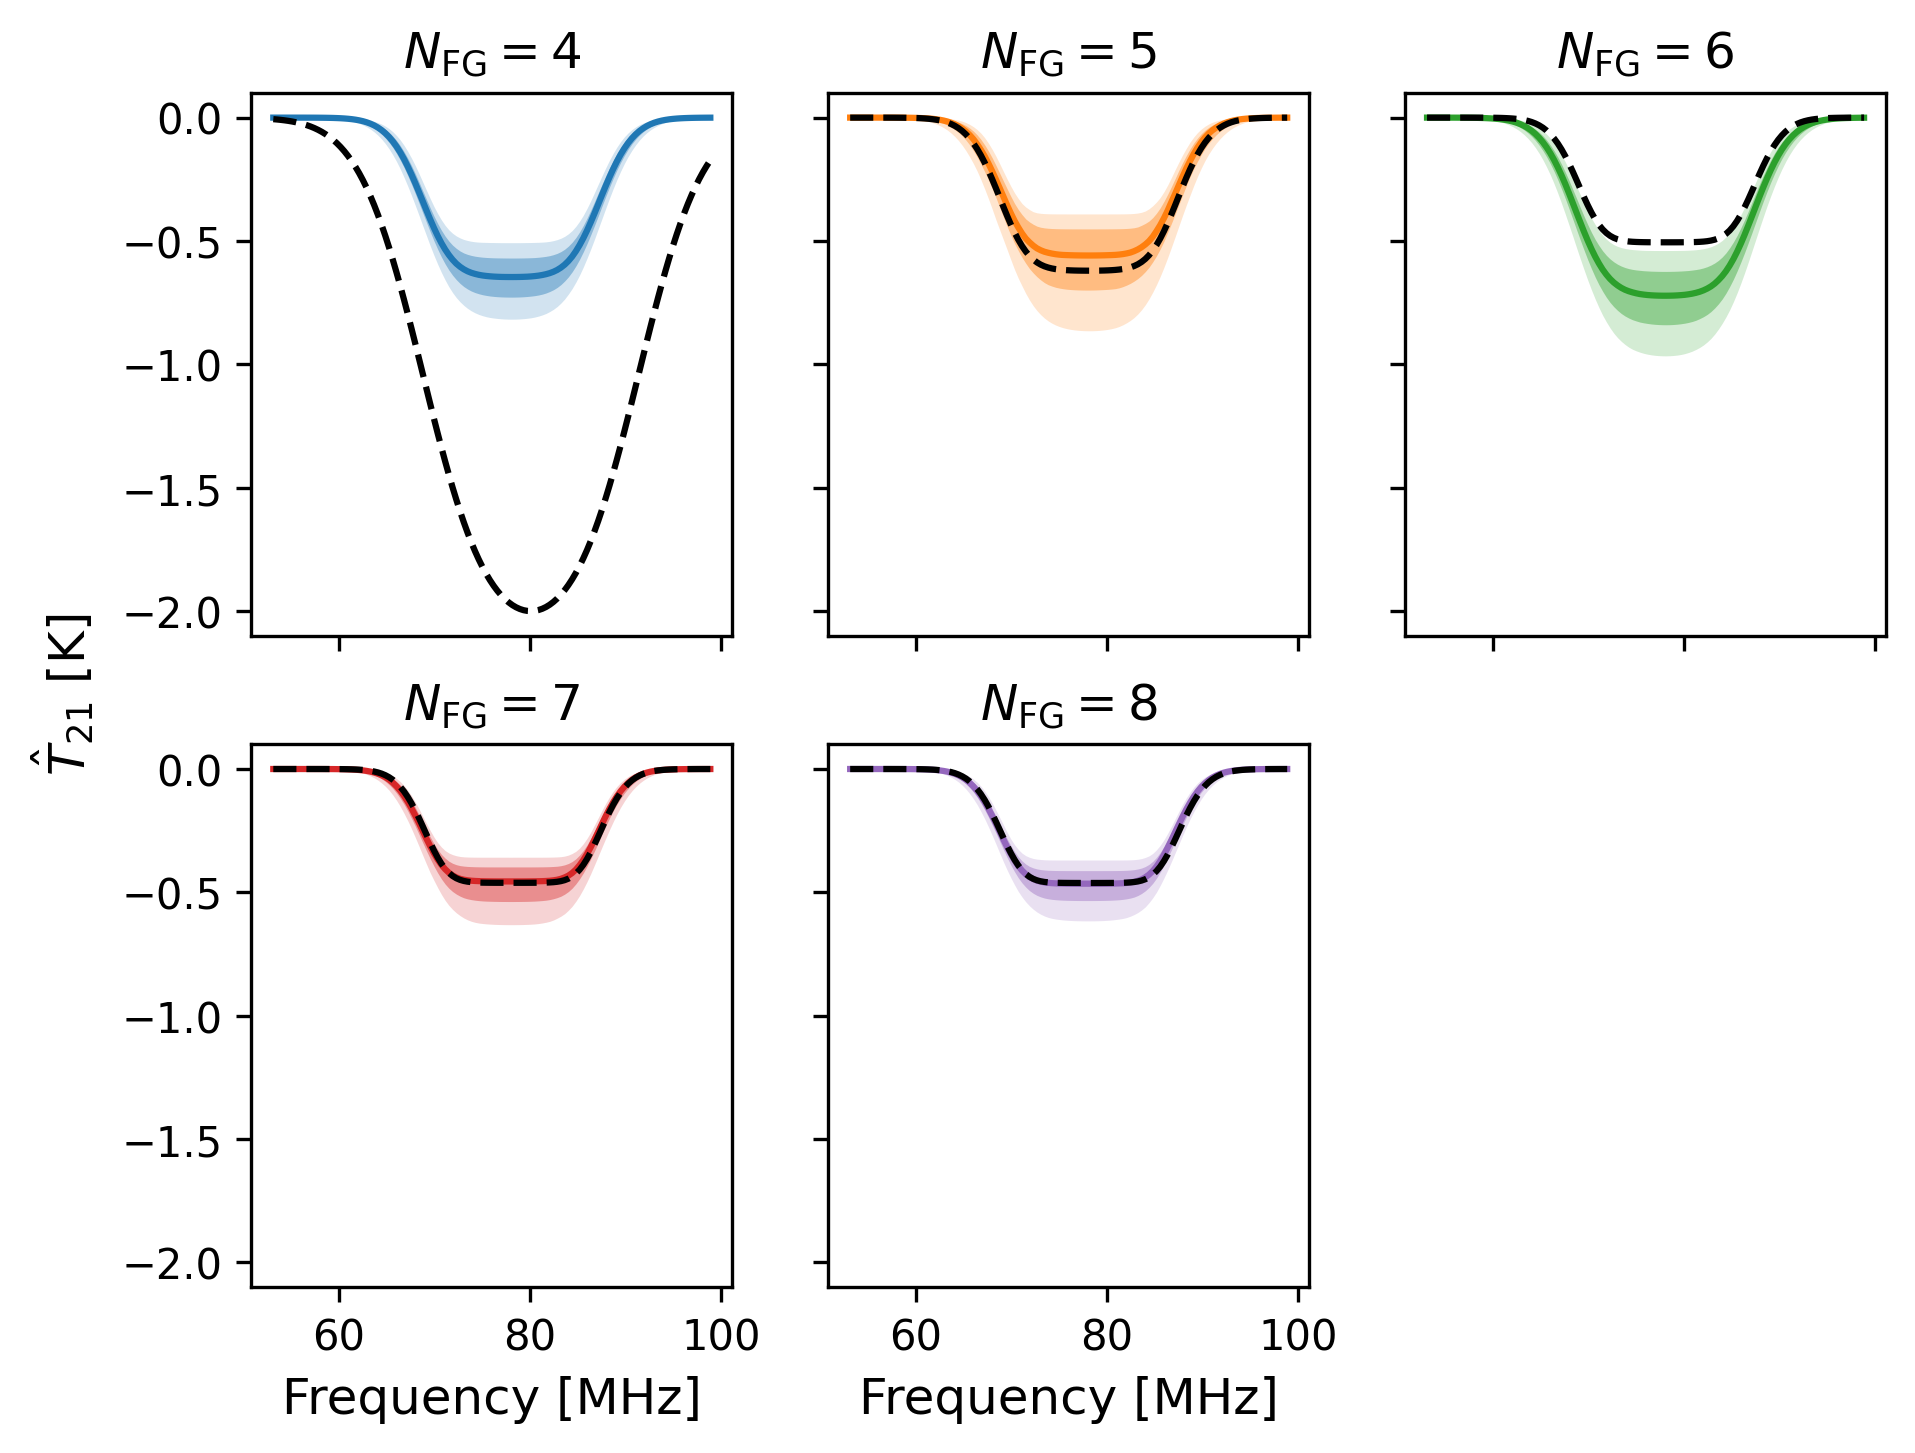

In [74]:
plot_inferred_absorption('median')